# Conditional DDPM на MNIST

Учебная реализация диффузионной модели с управляемой генерацией цифр (0-9).

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs("checkpoints", exist_ok=True)

In [2]:
T = 1000
BATCH_SIZE = 128
EPOCHS = 5
LR = 1e-4

## Загрузка MNIST

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Загрузка CIFAR-10

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Обучение

In [5]:
from UNet.unet import UNet
from Denoisers.DDPM import DDPM

unet = UNet(
    in_channels=3,
    out_channels=3,
    base_ch=128,
    emb_ch=512,
    depth=3,
    image_size=32,
    attention_levels=[1, 3]
).to(device)
ddpm = DDPM(unet, T=T, num_classes=10).to(device)
optimizer = optim.Adam(ddpm.parameters(), lr=LR)

for epoch in range(EPOCHS):
    ddpm.train()
    pbar = tqdm(dataloader)
    
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        loss = ddpm.training_step(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch} | Loss: {loss.item():.4f}")

torch.save(ddpm.state_dict(), f"checkpoints/ddpm_epoch{epoch}.pt")

Epoch 0 | Loss: 0.0385: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s]
Epoch 1 | Loss: 0.0438: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
Epoch 2 | Loss: 0.0585: 100%|██████████| 391/391 [01:50<00:00,  3.53it/s]
Epoch 3 | Loss: 0.0470: 100%|██████████| 391/391 [01:50<00:00,  3.53it/s]
Epoch 4 | Loss: 0.0427: 100%|██████████| 391/391 [01:49<00:00,  3.56it/s]
Epoch 5 | Loss: 0.0408: 100%|██████████| 391/391 [01:50<00:00,  3.53it/s]
Epoch 6 | Loss: 0.0344: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
Epoch 7 | Loss: 0.0472: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
Epoch 8 | Loss: 0.0268: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
Epoch 9 | Loss: 0.0285: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
Epoch 10 | Loss: 0.0423: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
Epoch 11 | Loss: 0.0273: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
Epoch 12 | Loss: 0.0418: 100%|██████████| 391/391 [01:54<00:00,  3.43it/s]
Epoch 13 | Loss: 0.0373: 100%|█████

## Генерация картинок по классам

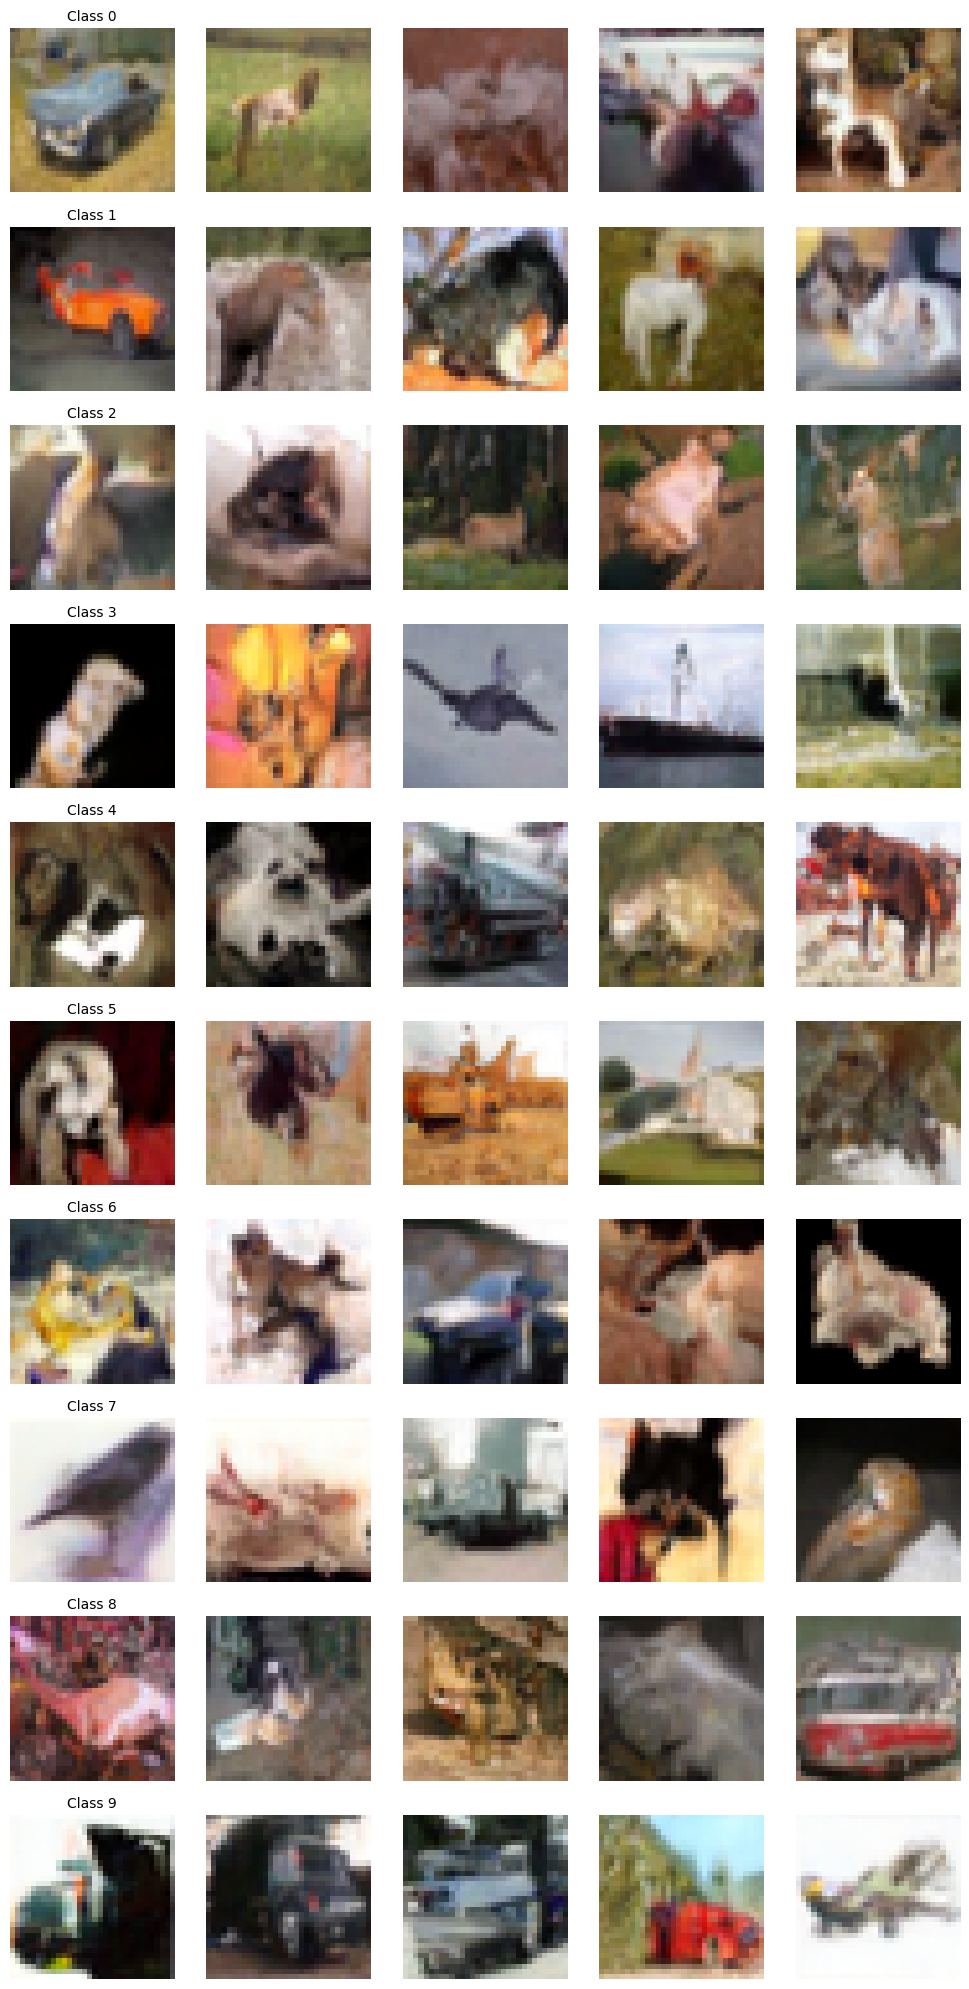

In [6]:
num_classes = 10
samples_per_class = 5

fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2, num_classes * 2))

for cls in range(num_classes):
    for i in range(samples_per_class):
        generated = ddpm.sample(cls, shape=(1, 3, 32, 32))
        img = generated.cpu().squeeze().clamp(-1, 1).add(1).div(2).permute(1, 2, 0)

        ax = axes[cls, i]
        ax.imshow(img, cmap='gray')
        ax.axis("off")
        
        if i == 0:
            ax.set_title(f"Class {cls}", fontsize=10)

plt.tight_layout()
plt.show()